In [1]:
!pip install PyALE

In [23]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree

from itertools import combinations
from collections import defaultdict
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import KBinsDiscretizer
import math

In [3]:
csv_file = "drive/MyDrive/credit_risk.csv"
df = pd.read_csv(csv_file)
target = df.columns[-1]
df = df.drop(columns=["S.No"])

In [4]:
df.head()

,Age,Income,Loan Amount,Credit Risk (Target)
0,25,Low,15000,High Risk
1,45,Medium,10000,Low Risk
2,30,High,25000,High Risk
3,50,Medium,8000,Low Risk
4,22,Low,18000,High Risk


In [5]:
labels_dict = {}
for col in ["Income", "Credit Risk (Target)"]:
    labels = LabelEncoder()
    df[col] = labels.fit_transform(df[col])
    labels_dict[col] = labels

x = df.drop(columns=["Credit Risk (Target)"])
y = df["Credit Risk (Target)"]


In [6]:
x.head()

,Age,Income,Loan Amount
0,25,1,15000
1,45,2,10000
2,30,0,25000
3,50,2,8000
4,22,1,18000


In [7]:
y.head()

,Credit Risk (Target)
0,0
1,1
2,0
3,1
4,0


In [8]:
for feature, encoder in labels_dict.items():
    print(f"{feature}: {encoder.classes_}, {encoder.transform(encoder.classes_)}")

Income: ['High' 'Low' 'Medium'], [0 1 2]
Credit Risk (Target): ['High Risk' 'Low Risk'], [0 1]


#Question 1

In [28]:
def learn_rule(data, target, positive_class):

    rule_conditions = []
    current_data = data.copy()
    used_attributes = set()

    while current_data[target].nunique() > 1:
        best_condition = None
        best_quality = 0
        best_subset = None


        for col in data.columns:
            if col == target or col in used_attributes:
                continue

            for val in current_data[col].unique():
                subset = current_data[current_data[col] == val]
                if len(subset) == 0:
                    continue
                pos_count = (subset[target] == positive_class).sum()
                total = len(subset)
                quality = pos_count / total

                if quality > best_quality:
                    best_quality = quality
                    best_condition = (col, val)
                    best_subset = subset

        if best_condition is None:
            break
        rule_conditions.append(best_condition)
        used_attributes.add(best_condition[0])
        current_data = best_subset


        if current_data[target].nunique() == 1 and current_data[target].iloc[0] == positive_class:
            return rule_conditions, current_data

    if current_data[target].nunique() == 1 and current_data[target].iloc[0] == positive_class:
        return rule_conditions, current_data
    else:
        return None, None

def sequential_covering(data, target, positive_class):

    rules = []
    remaining_data = data.copy()

    while True:
        positive_remaining = remaining_data[remaining_data[target] == positive_class]
        if len(positive_remaining) == 0:
            break
        rule, covered_data = learn_rule(remaining_data, target, positive_class)
        if rule is None:
            break
        rules.append((rule, covered_data))

        remaining_data = remaining_data.drop(covered_data.index)

    return rules

csv_file = "drive/MyDrive/credit_risk.csv"
df = pd.read_csv(csv_file)
df = df.drop(columns=["S.No"])
target = df.columns[-1]
class_counts = df[target].value_counts()
positive_class = class_counts.idxmin()

binning_df = df.copy()
freq_df = df.copy()
numeric_cols = ["Age", "Loan Amount"]
bins = 6

for col in numeric_cols:
    binning_df[col] = pd.cut(df[col], bins=bins, duplicates='drop')
    freq_df[col] = pd.qcut(df[col], q=bins, duplicates='drop')

rules_binning = sequential_covering(binning_df, target, positive_class)
rules_freq = sequential_covering(freq_df, target, positive_class)

print("Method Equal binning: ")
for i, (rule, covered_data) in enumerate(rules_binning):
    rule_str = " ".join([f"{col} == {val}" for col, val in rule])
    print(f"\nRule {i}: {rule_str}")
    print(covered_data)

print("Mthod Equal Frequency")
for i, (rule, covered_data) in enumerate(rules_freq):
    rule_str = " ".join([f"{col} == {val}" for col, val in rule])
    print(f"\nRule {i}: {rule_str}")
    print("Selected data points:")
    print(covered_data)


Method Equal binning: 

Rule 0: Age == (44.0, 49.5]
            Age  Income            Loan Amount Credit Risk (Target)
1  (44.0, 49.5]  Medium  (9166.667, 13333.333]             Low Risk

Rule 1: Age == (49.5, 55.0]
            Age  Income         Loan Amount Credit Risk (Target)
3  (49.5, 55.0]  Medium  (4975.0, 9166.667]             Low Risk
6  (49.5, 55.0]  Medium  (4975.0, 9166.667]             Low Risk
Mthod Equal Frequency

Rule 0: Age == (41.667, 49.167]
Selected data points:
                Age  Income            Loan Amount Credit Risk (Target)
1  (41.667, 49.167]  Medium  (8333.333, 11666.667]             Low Risk

Rule 1: Age == (49.167, 55.0]
Selected data points:
              Age  Income           Loan Amount Credit Risk (Target)
3  (49.167, 55.0]  Medium  (4999.999, 8333.333]             Low Risk
6  (49.167, 55.0]  Medium  (4999.999, 8333.333]             Low Risk


#Question 2

In [9]:
csv_file = "drive/MyDrive/credit_risk.csv"
df = pd.read_csv(csv_file)
target = df.columns[-1]
df = df.drop(columns=["S.No"])

In [10]:
labels_dict = {}
for col in ["Income", "Credit Risk (Target)"]:
    labels = LabelEncoder()
    df[col] = labels.fit_transform(df[col])
    labels_dict[col] = labels

x = df.drop(columns=["Credit Risk (Target)"])
y = df["Credit Risk (Target)"]


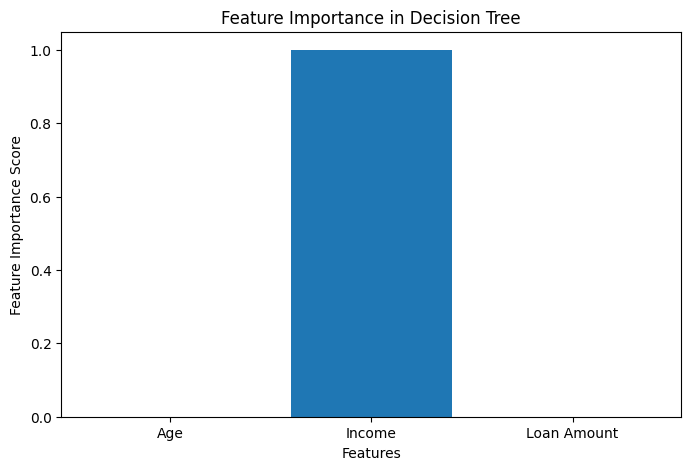


Rules are: |--- Income <= 1.50
|   |--- class: 0
|--- Income >  1.50
|   |--- class: 1



In [11]:
decision_tree_model = DecisionTreeClassifier(criterion="gini", random_state=42)
decision_tree_model.fit(x, y)
tree_rules = export_text(decision_tree_model, feature_names=list(x.columns))


feature_importance = decision_tree_model.feature_importances_
plt.figure(figsize=(8, 5))
plt.bar(x.columns, feature_importance)
plt.ylabel("Feature Importance Score")
plt.xlabel("Features")
plt.title("Feature Importance in Decision Tree")
plt.show()
print()

print("Rules are:", tree_rules)



#Question 3

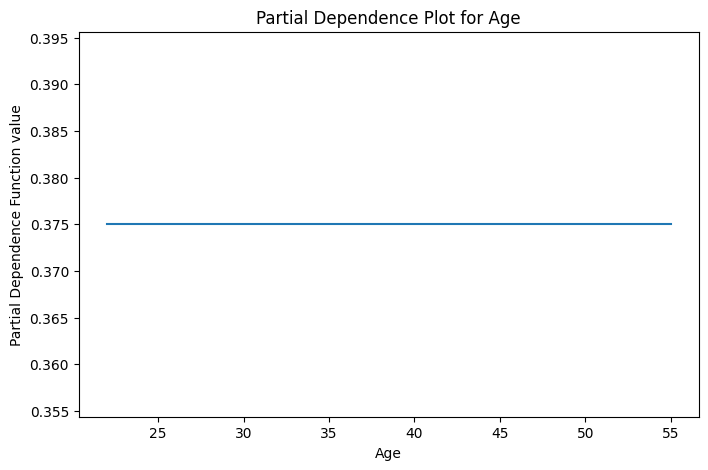

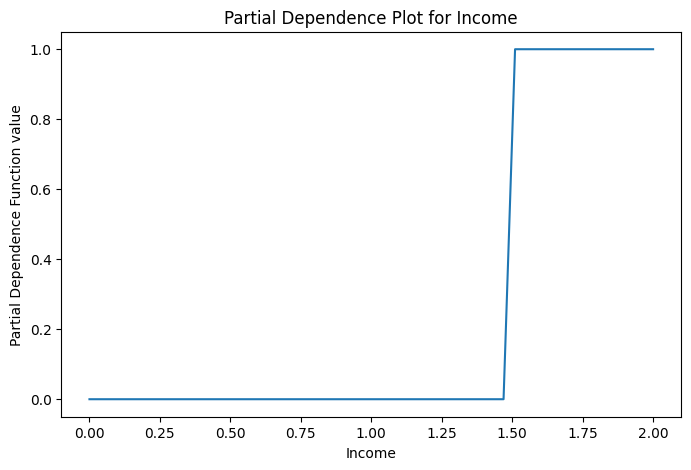

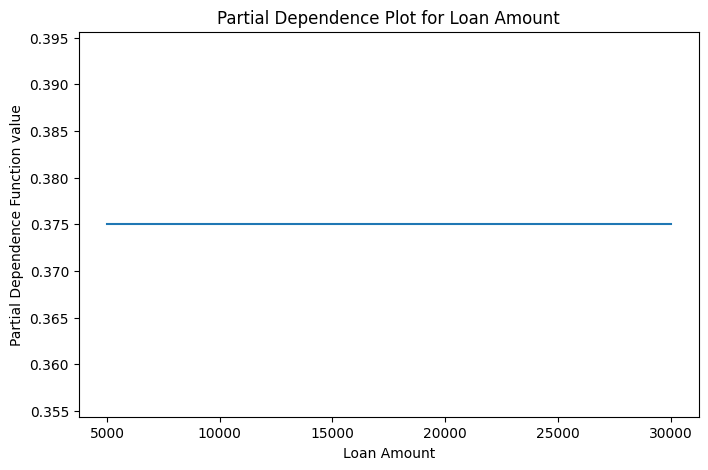

In [12]:
def pdp(dataset, model, feature):

    feature_range_values = np.linspace(dataset[feature].min(), dataset[feature].max(), 50)
    # print(feature_range_values)
    feature_pdp_values = []

    for value in feature_range_values:
        df = dataset.copy()
        df[feature] = value
        y_hat = model.predict(df)
        feature_pdp_values.append(np.mean(y_hat))

    return feature_range_values, feature_pdp_values

feature_list = list(x.columns)

for feature in feature_list:
    feature_range, pdp_value = pdp(x, decision_tree_model, feature)

    plt.figure(figsize=(8, 5))
    plt.plot(feature_range, pdp_value)
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence Function value')
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.show()

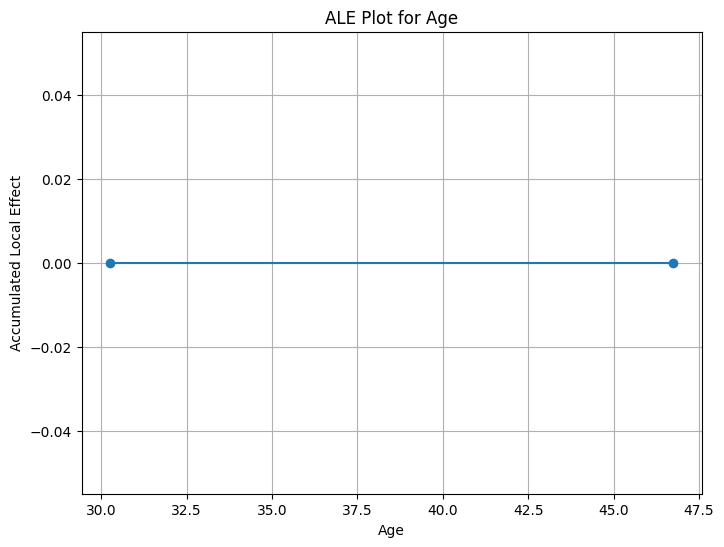

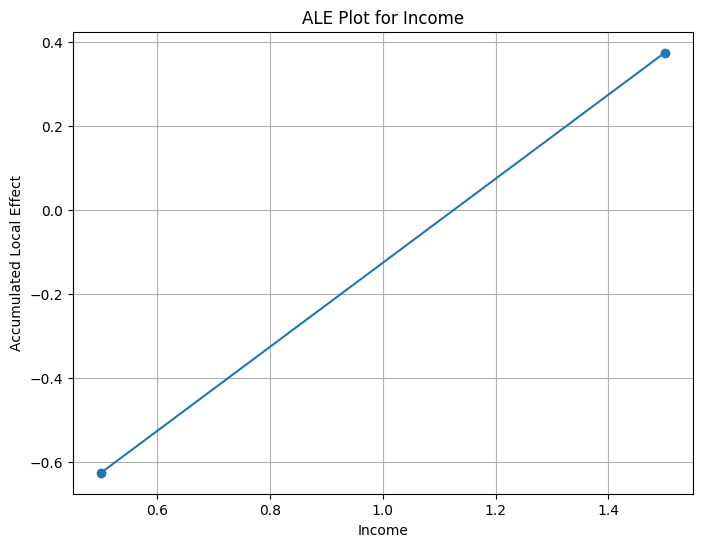

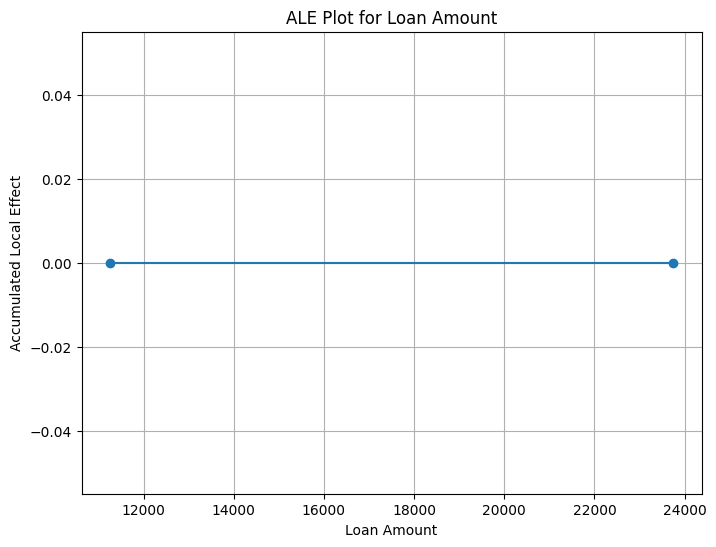

In [26]:
def ale(dataset, model, feature, is_classification=True, class_idx=1):

    no_bins = int(math.sqrt(len(dataset)))
    feature_val = dataset[feature]
    bins = np.linspace(feature_val.min(), feature_val.max(), no_bins + 1)
    # print(bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0

    local_effects = [0 for i in range(no_bins)]
    count = [0 for i in range(no_bins)]

    binwise_local_effect = []
    for i in range(no_bins):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        if i < no_bins - 1:
            index = x[(x[feature] >= lower_bound) & (x[feature] < upper_bound)].index
        else:
            index = x[(x[feature] >= lower_bound) & (x[feature] <= upper_bound)].index

        if len(index) > 0:
            count[i] = len(index)

            X_lower = dataset.loc[index].copy()
            X_upper = dataset.loc[index].copy()
            X_lower[feature] = lower_bound
            X_upper[feature] = upper_bound
            # print(X_lower)
            # print(X_upper)

            preds_lower = model.predict_proba(X_lower)[:, class_idx]
            preds_upper = model.predict_proba(X_upper)[:, class_idx]

            # print(preds_upper, preds_lower)
            local_effects[i] = np.mean(preds_upper - preds_lower)


    accumulated_effect = np.cumsum(local_effects)
    # print(accumulated_effect)

    overall_effect = np.sum(accumulated_effect * count) / np.sum(count)
    ale_values = accumulated_effect - overall_effect

    return bin_centers, ale_values


feature_list = list(x.columns)

for feature in feature_list:
    bin_centers, ale_values = ale(x, decision_tree_model, feature, is_classification=True, class_idx=1)
    # print(len(bin_centers))
    # 4. Plot the ALE
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, ale_values, marker='o')
    plt.xlabel(feature)
    plt.ylabel("Accumulated Local Effect")
    plt.title(f"ALE Plot for {feature}")
    plt.grid(True)
    plt.show()


INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.


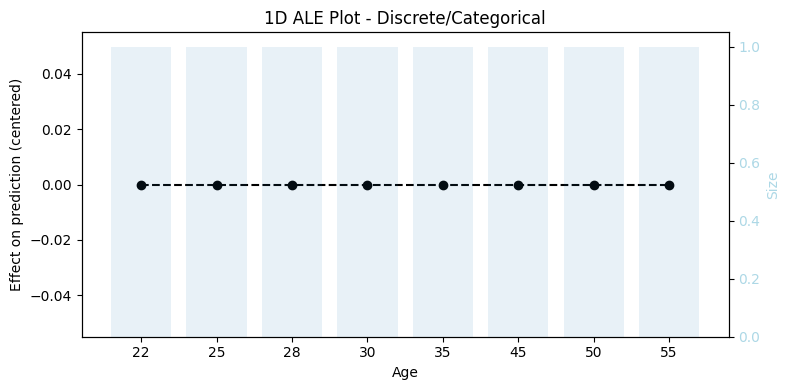

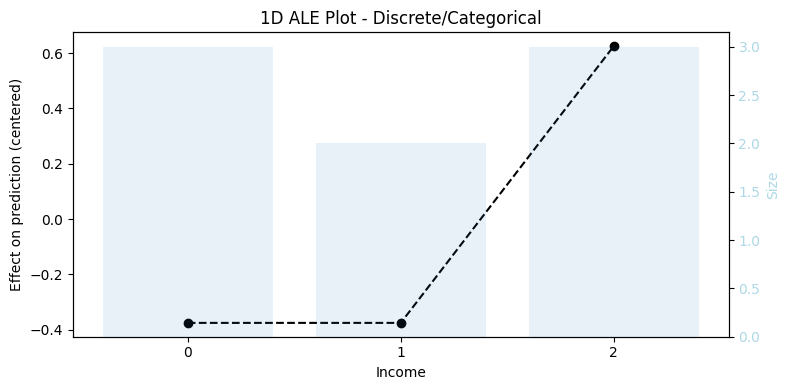

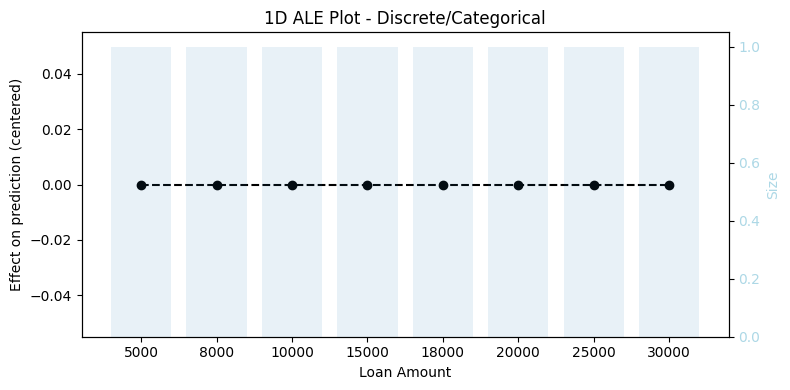

In [24]:
feature_list = list(x.columns)

for feature in feature_list:
    ale_eff = ale(X = x, model = decision_tree_model, feature=[feature], grid_size=50)


#Question 4

Rules are: |--- Income <= 1.50
|   |--- class: 0
|--- Income >  1.50
|   |--- class: 1


Thresholds (breaking points) for feature 'Income': [1.5]


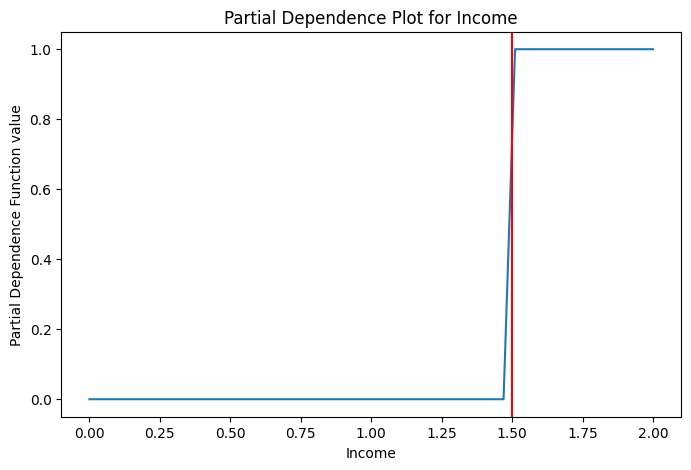

In [152]:
tree_rules = export_text(decision_tree_model, feature_names=list(x.columns))
print("Rules are:", tree_rules)


tree = decision_tree_model.tree_
thresholds = []
feature = "Income"
features_list = list(x.columns)
for node in range(tree.node_count):
    if tree.children_left[node] != tree.children_right[node]:
       if features_list[tree.feature[node]] == feature:
                thresholds.append(tree.threshold[node])

print(f"\nThresholds (breaking points) for feature '{feature}': {thresholds}")

feature_range, pdp_value = pdp(x, decision_tree_model, feature)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(feature_range, pdp_value)
for thr in thresholds:
    ax.axvline(x=thr, color='red')
plt.xlabel(feature)
plt.ylabel('Partial Dependence Function value')
plt.title(f'Partial Dependence Plot for {feature}')
plt.show()